# Project 1: End-to-End Pipeline to Classify News Articles

##### Group Member
Yifu Yuan, 804973353  
Zhiquan You, 205667859  
Wenxuan Wu, 705846929

#### Data Preparation

In [144]:
import pandas as pd

dataset = pd.read_csv("project1_dataset.csv")
dataset.head()

,Unnamed: 0,full_text,summary,keywords,publish_date,authors,url,leaf_label,root_label
0,590,Having made a massive impact in Saudi Arabia w...,Having made a massive impact in Saudi Arabia w...,"['singhs', 'rooting', 'cool', 'saudi', 'style'...",NaN,[],https://www.msn.com/en-in/entertainment/other/...,cricket,sports
1,388,Cricket is all about the emotional rollercoast...,"No matter which team fans hope to win, every s...","['wants', 'fans', 'finals', 'cup', 'win', 'tou...",NaN,[],https://www.prnewswire.com:443/news-releases/c...,cricket,sports
2,423,New Zealand announces back-to-back tours next ...,New Zealand announces back-to-back tours next ...,"['test', 'west', 'tour', 'zealand', 'world', '...",2021-12-20 00:00:00,[],https://www.aljazeera.com/news/2021/12/20/cric...,cricket,sports
3,563,It's not the first time cricket fans in the co...,Billed as one of the pre-tournament favourites...,"['qualify', 'afghanistan', 'cup', 'world', 'ze...",NaN,[],https://www.msn.com/en-in/news/other/t20-world...,cricket,sports
4,634,An employee works on a computer terminal again...,"REUTERS/Sivaram VBENGALURU, Oct 11 (Reuters Br...","['success', 'tech', 'startup', 'talent', 'onli...",2021-10-11 00:00:00,['Una Galani'],https://www.reuters.com/breakingviews/india-in...,cricket,sports


## Getting familiar with the dataset

### Question 1

##### part 1

In [2]:
dataset.shape

(2072, 9)

There are 2072 samples and 9 features

##### part 2

**a)**

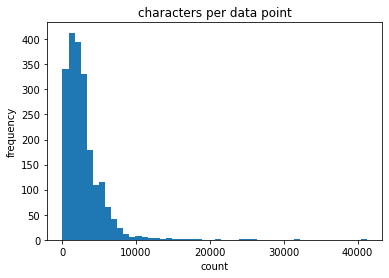

In [3]:
import matplotlib.pyplot as plt

full_texts = dataset["full_text"]
full_texts_len = [len(text) for text in full_texts]
plt.hist(full_texts_len, bins=50)
plt.ylabel('frequency')
plt.xlabel('count')
plt.title('characters per data point')

plt.show()

**b)**

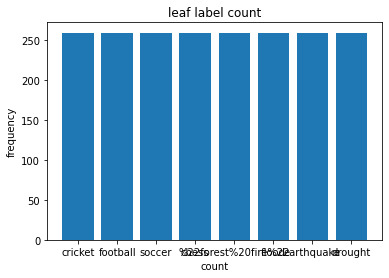

In [4]:
from collections import Counter

leaf_labels = dataset['leaf_label']
leaf_labels_counter = Counter(leaf_labels)

plt.bar(leaf_labels_counter.keys(), leaf_labels_counter.values())
plt.ylabel('frequency')
plt.xlabel('count')
plt.title('leaf label count')

plt.show()


**c)**

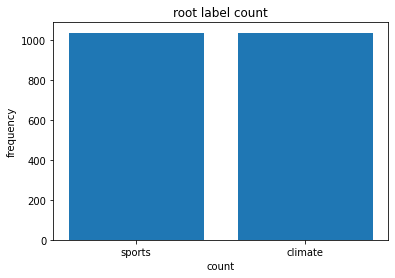

In [5]:
root_labels = dataset['root_label']
root_labels_counter = Counter(root_labels)

plt.bar(root_labels_counter.keys(), root_labels_counter.values())
plt.ylabel('frequency')
plt.xlabel('count')
plt.title('root label count')

plt.show()

##### part 3

1. From the full text length plot, we can see that most of the samples are short, with no more than 10,000 characters. But there exists some long texts with length up to 40,000.
2. From the leaf and root label graphs, we can see that all labels are equally distributed; labels in leaf and root labels have same number of samples in the dataset, respectively. From leaf label count bar plot we observe that frequency of 8 leaf label classes have the count of 259 and in the root labels histogram, there are frequency of 2 root label classes with the count of 1036.

## Binary Classification

##### Set Seed

In [145]:
import numpy as np
import random
np.random.seed(42)
random.seed(42)

##### Split Training and Testing Data

In [146]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset[["full_text","root_label", "leaf_label", "keywords"]], test_size=0.2)

### Question 2

In [64]:
len(train), len(test)

(1657, 415)

There are 1657 training samples and 415 testing samples

### Question 3

##### Text Cleaning

In [147]:
import re
import string
# Remove url, number and punctuations here
def clean(text):
    text = re.sub(r'https?://[^\s]+', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"[0-9]", "", texter)
    texter = re.compile('[%s]' % re.escape(string.punctuation)).sub('', texter)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

In [148]:
train_texts = train['full_text']
test_texts = test['full_text']
clean_texts_train = []
clean_texts_test = []
for text in train_texts:
    clean_texts_train.append(clean(text))
for text in test_texts:
    clean_texts_test.append(clean(text))
    
assert len(clean_texts_train) + len(clean_texts_test) == len(dataset['full_text'])

##### Obtain Vocabulary From Training Data

In [149]:
import nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Remove stopwords by CountVectorizer and get pos_tags of vocab list
vectorizer = CountVectorizer(min_df=3, stop_words='english')
data_matrix = vectorizer.fit_transform(clean_texts_train)
tokens = vectorizer.get_feature_names()
pos_tags = nltk.pos_tag(tokens)

# Lemmatize vocab list by pos_tag
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'
    elif treebank_tag.startswith('V'):
        return 'v'
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('R'):
        return 'r'
    else:
        return 'n'
wnl = WordNetLemmatizer()
vocab = [wnl.lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
vocab = list(set(vocab))
print("Length of vocabulary is {}".format(len(vocab)))

# PorterStemmer


[nltk_data] Downloading package wordnet to /Users/zacyou/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/zacyou/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Length of vocabulary is 9693


##### TF-IDF Transformation

In [150]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('count', CountVectorizer(vocabulary=vocab)),
                 ('tfid', TfidfTransformer())]).fit(clean_texts_train)
train_matrix = pipe['count'].transform(clean_texts_train).toarray()
train_idf_matrix = pipe.transform(clean_texts_train)
test_idf_matrix = pipe.transform(clean_texts_test)


In [129]:
train_idf_matrix.shape, test_idf_matrix.shape

((1657, 9693), (415, 9693))

##### Part 1

1. Stemming is a procedure to get rid of inflectional and derivational suffixes from the words and aims to merge different word forms into one canonical form. Stemming has the advantage of efficiency as it does not care about pos tag; all it has to do is to shrink each token to its stem. The disadvantage is also obvious as stemming cannot distinguish token meaning and context and often outputs non-English words as intermediate results.
2. Lemmatization is a procedure to reduce an inflectional or derivational word form to the dictionary form and group together words with the same root or lemma but with different derivatives of meaning as one term. It often uses the context in which the word is being used, as opposed to stemming which only uses the stem of word. The pros of lemmatization is that it can maintain morphological information of words in different context, which makes it suitable for more tasks instead of merely keeping track of frequencies of tokens. On the other hand, this functionality comes at the cost of more computation than stemming.
3. Intuitively, lemmatization will keep track of multiple forms of a word, i.e., noun, adj, adv and so on. Therefore, lemmatization will result in a bigger dictionary than stemming.

##### Part 2

min_df is used for removing the terms that appear too infrequently in the documents. It means that if a word appears in less than min_df number of documents, it will ignore that term. Conversely, if a word appears more than min_df documents, it will be recorded in the vocabulary. In other words, this parameter acts like a shreshold of word frequency in the vocabulary. Thus, a larger min_df will shrink the column size of TF-IDF matrix and a smaller min_df will expand it.

##### Part 3

1. Stopwords should be removed BEFORE lemmatizing since some of the stopwords in a text would be lemmatized and therefore if we do it after lemmatizing, some stopwords in the corpus will be changed and thus cannot be removed as a result of mismatch.
2. Punctuations should be removed BEFORE lemmatizing because words together with punctuations might cause failed lemmatizing. Plus, it really helps to get rid of the unhelpful parts of the data, also known as noise so that we can better perform text analysis.
3. Since we are dealing with text data, so the number does not add much information to our text processing. Therefore, numbers should be removed BEFORE lemmatizing because of the same reason as punctuations; to make it easier for us to perform text analysis.

##### Part 4

The dimensions of training and testing TF-IDF matrices are 1657x9693 and 415x9693, respectively.

#### Dimensionality Reduction

### Question 4

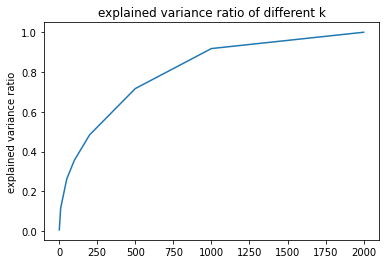

In [14]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
k_list = [1, 10, 50, 100, 200, 500, 1000, 2000]
explained_ratio = []
for k in k_list:
    svd = TruncatedSVD(n_components=k)
    svd.fit(train_idf_matrix)
    explained_ratio.append(svd.explained_variance_ratio_.sum())

plt.plot(k_list, explained_ratio)
plt.title('explained variance ratio of different k')
plt.ylabel('explained variance ratio')
plt.show()

In [105]:
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import NMF
import numpy as np

U, S, Vt = randomized_svd(train_idf_matrix, n_components=50)
MSE_LSI = np.linalg.norm(train_idf_matrix - U.dot(np.diag(S)).dot(Vt), 'fro') ** 2

nmf = NMF(n_components=50)
MSE_NMF = np.linalg.norm(train_idf_matrix - nmf.fit_transform(train_idf_matrix).dot(nmf.components_), 'fro') ** 2

print("RR MSE of LSI is {}".format(MSE_LSI))
print("RR MSE of NMF is {}".format(MSE_NMF))

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/utils/extmath.py:368: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


RR MSE of LSI is 1185.7457736560957
RR MSE of NMF is 1206.0318339558607


In [16]:
print(explained_ratio)

[0.006097741202834256, 0.11572900437564622, 0.26226012766266, 0.35649291848431874, 0.4839868863806788, 0.7166974335991914, 0.9179594156916051, 1.0000000000000002]


##### part 1 

1. The explained variance ratio is the percentage of variance that is attributed by each of the component. From our chart we can observe that As the value of k (number of desired dimensionality of the output data) increases, the cumulative explained variance ratio also gradually increases. 
2. The graph's concavity indicates the amount of data that can be described in the first 1000 components (or number of dimensions) is more than that of the latter components, although it is noted that the cumulative explained variance is lower than 1.0 when the number of components is less than 2000, indicating that the features are more or less related with each other.

##### part 2

As we can see, the reconstruction residual error for NMF is larger than the error of the LSI. That might be because in the NMF, it has both the non negative matrices W and H, which is one of its strict requirements stated by its definition. That limits the degree of freedom of the NMF to find the vectors that can minimize the error. While LSI doesn't have this restriction and thus it has more degree of freedom of finding the best vectors.

##### Classification Algorithms

### Question 5

##### Part 1

In [151]:
from sklearn.svm import SVC
hard_SVM = SVC(kernel='linear', C=1000, probability=True)
soft_SVM = SVC(kernel='linear', C=0.0001, probability=True)

reduced_train_matrix = train_idf_matrix.dot(Vt.T)
reduced_test_matrix = test_idf_matrix.dot(Vt.T)
print(reduced_train_matrix.shape)
print(reduced_test_matrix.shape)

train_labels = list(train['root_label'])
test_labels = list(test['root_label'])
hard_SVM.fit(reduced_train_matrix, train_labels)
soft_SVM.fit(reduced_train_matrix, train_labels)

print(hard_SVM.score(reduced_test_matrix, test_labels))
print(soft_SVM.score(reduced_test_matrix, test_labels))

(1657, 50)
(415, 50)
0.9590361445783132
0.4963855421686747


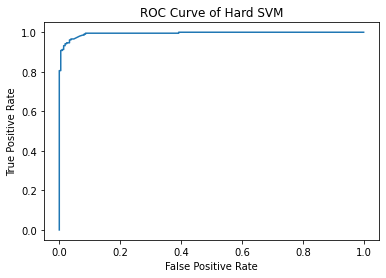

In [152]:
from sklearn import metrics
predict_proba = hard_SVM.predict_proba(reduced_test_matrix)
climate_proba = [predict_proba[i][0] for i in range(len(predict_proba))]

fpr, tpr, thresholds = metrics.roc_curve(test_labels, climate_proba, pos_label='climate')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Hard SVM')
plt.show()

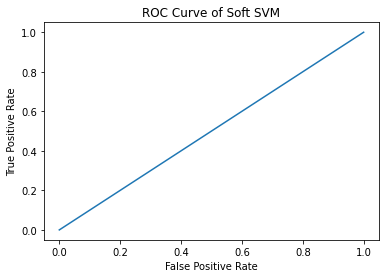

In [153]:
predict_proba = soft_SVM.predict_proba(reduced_test_matrix)
climate_proba = predict_proba[:,1]

fpr, tpr, thresholds = metrics.roc_curve(test_labels, climate_proba, pos_label='climate')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Soft SVM')
plt.show()

In [154]:
hard_SVM_prediction = hard_SVM.predict(reduced_test_matrix)
soft_SVM_prediction = soft_SVM.predict(reduced_test_matrix)
confusion_matrix_hard = metrics.confusion_matrix(y_true=test_labels, y_pred=hard_SVM_prediction, labels=['sports', 'climate'])
confusion_matrix_soft = metrics.confusion_matrix(y_true=test_labels, y_pred=soft_SVM_prediction, labels=['sports', 'climate'])

print("The following is the confusion matrix for hard SVM:")
print(confusion_matrix_hard)
print("The following is the confusion matrix for soft SVM:")
print(confusion_matrix_soft)

The following is the confusion matrix for hard SVM:
[[202   7]
 [ 10 196]]
The following is the confusion matrix for soft SVM:
[[  0 209]
 [  0 206]]


In [155]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

accuracy = accuracy_score(test_labels, hard_SVM_prediction)
precision = precision_score(test_labels, hard_SVM_prediction, average='macro')
recall = recall_score(test_labels, hard_SVM_prediction, average='macro')
f1 = f1_score(test_labels, hard_SVM_prediction, average='macro')

print("Precision of hard SVM is {}".format(precision))
print("Recall of hard SVM is {}".format(recall))
print("F1-Score of hard SVM is {}".format(f1))
print("Accuracy of hard SVM is {}".format(accuracy))

Precision of hard SVM is 0.9591737150292778
Recall of hard SVM is 0.9589817438565522
F1-Score of hard SVM is 0.9590275801590114
Accuracy of hard SVM is 0.9590361445783132


In [156]:
accuracy = accuracy_score(test_labels, soft_SVM_prediction)
precision = precision_score(test_labels, soft_SVM_prediction, average='macro')
recall = recall_score(test_labels, soft_SVM_prediction, average='macro')
f1 = f1_score(test_labels, soft_SVM_prediction, average='macro')

print("Precision of soft SVM is {}".format(precision))
print("Recall of soft SVM is {}".format(recall))
print("F1-Score of soft SVM is {}".format(f1))
print("Accuracy of soft SVM is {}".format(accuracy))

Precision of soft SVM is 0.24819277108433735
Recall of soft SVM is 0.5
F1-Score of soft SVM is 0.33172302737520126
Accuracy of soft SVM is 0.4963855421686747


/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [157]:
very_hard_SVM = SVC(kernel='linear', C=100000, probability=True)
very_hard_SVM.fit(reduced_train_matrix, train_labels)
very_hard_SVM_prediction = very_hard_SVM.predict(reduced_test_matrix)
confusion_matrix_very_hard = metrics.confusion_matrix(y_true=test_labels, y_pred=very_hard_SVM_prediction, labels=['sports', 'climate'])

accuracy = accuracy_score(test_labels, very_hard_SVM_prediction)
precision = precision_score(test_labels, very_hard_SVM_prediction, average='macro')
recall = recall_score(test_labels, very_hard_SVM_prediction, average='macro')
f1 = f1_score(test_labels, very_hard_SVM_prediction, average='macro')
print("Precision of y=100000 SVM is {}".format(precision))
print("Recall of y=100000 SVM is {}".format(recall))
print("F1-Score of y=100000 SVM is {}".format(f1))
print("Accuracy of y=100000 SVM is {}".format(accuracy))

Precision of y=100000 SVM is 0.9591737150292778
Recall of y=100000 SVM is 0.9589817438565522
F1-Score of y=100000 SVM is 0.9590275801590114
Accuracy of y=100000 SVM is 0.9590361445783132


a. The two ROC plots and all metrics are reported as above. We can observe that the hard SVM performs better as its metrics outperform those of soft SVM. Therefore, the hard SVM is better than the soft SVM.  

b. For SVM with trade-off parameter y being 100000, we can see that its metrics are identical to those of hard SVM, which shows that a huge trade-off parameter does not guarantee to improve model performance, or it might even overfit the model.

c. The ROC curve of the soft margin SVM look not competitive. From the confusion matrix of soft SVM, we can see that it classifies all instances to be 'climate'. As there are almost the same number of instances from two labels, the resulting model is no better than a coin flip. The reason for such poor classificaion power is because of  the small trade-off parameter which causes the model to underfit. When y=0.0001, the model almost does not penalize misclassification but only focuses on maximizing the margin between two classes. Therefore, the model chooses to classify all instances to be 'climiate' in order to maximize the margin. Hence, the soft SVM does not perform well.

*. The ROC Curve of the soft margin SVM does not loop competitive. Intuitively, we only need to focus on the area under the curve (AUC) of a ROC Curve plot. For the soft SVM case, its AUC is very small, indicating a poor inferring power, which makes it not as competitive as hard SVM in this case.

##### Part 2

In [158]:
from sklearn.model_selection import cross_val_score

trade_off_para = [10**k for k in range(-3, 7, 1)]
best_score = 0
best_y = 0
for y in trade_off_para:
    clf = SVC(kernel='linear', C=y)
    mean_score = np.mean(cross_val_score(clf, reduced_train_matrix, train_labels, cv=5))
    if mean_score > best_score:
        best_score = mean_score
        best_y = y

In [159]:
print('The best trade-off parameter y is {}'.format(best_y))

The best trade-off parameter y is 100


In [160]:
best_SVM = SVC(kernel='linear', C=best_y, probability=True)
best_SVM.fit(reduced_train_matrix, train_labels)
best_SVM_prediction = best_SVM.predict(reduced_test_matrix)
confusion_matrix_best = metrics.confusion_matrix(y_true=test_labels, y_pred=best_SVM_prediction, labels=['sports', 'climate'])

accuracy = accuracy_score(test_labels, best_SVM_prediction)
precision = precision_score(test_labels, best_SVM_prediction, average='macro')
recall = recall_score(test_labels, best_SVM_prediction, average='macro')
f1 = f1_score(test_labels, best_SVM_prediction, average='macro')
print("The following is the confusion matrix of gamma=100")
print(confusion_matrix_best)
print("Precision of best SVM is {}".format(precision))
print("Recall of best SVM is {}".format(recall))
print("F1-Score of best SVM is {}".format(f1))
print("Accuracy of best SVM is {}".format(accuracy))

The following is the confusion matrix of gamma=100
[[206   3]
 [ 11 195]]
Precision of best SVM is 0.9670786203044268
Recall of best SVM is 0.9661239373809635
F1-Score of best SVM is 0.9662413424441035
Accuracy of best SVM is 0.9662650602409638


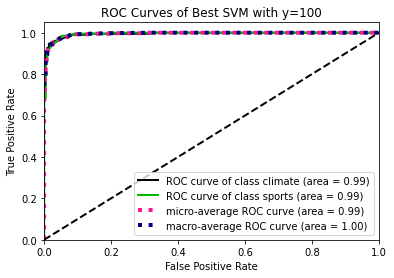

In [167]:
predict_proba = best_SVM.predict_proba(reduced_test_matrix)

skplt.metrics.plot_roc(test_labels, predict_proba, title='ROC Curves of Best SVM with y=100')
plt.show()

### Question 6

##### part 1

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


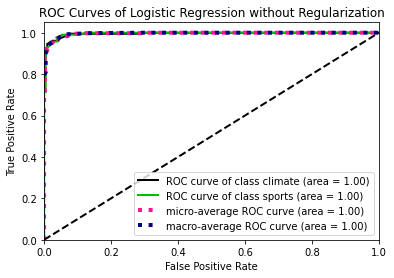

In [28]:
from sklearn.linear_model import LogisticRegression

logistic_clf = LogisticRegression(solver='saga', penalty='none')
logistic_clf.fit(reduced_train_matrix, train_labels)
logistic_prediction = logistic_clf.predict(reduced_test_matrix)

predict_proba = logistic_clf.predict_proba(reduced_test_matrix)

skplt.metrics.plot_roc(test_labels, predict_proba, title='ROC Curves of Logistic Regression without Regularization')
plt.show()

In [168]:
confusion_matrix_logistic = metrics.confusion_matrix(y_true=test_labels, y_pred=logistic_prediction, labels=['sports', 'climate'])
print("The confusion matrix of logistic regression without regularization is as following:")
print(confusion_matrix_logistic)

acc_0 = accuracy_score(test_labels, best_SVM_prediction)
precision_0 = precision_score(test_labels, logistic_prediction, average='macro')
recall_0 = recall_score(test_labels, logistic_prediction, average='macro')
f1_0 = f1_score(test_labels, logistic_prediction, average='macro')
print("Precision of logistic regression is {}".format(precision_0))
print("Recall of logistic regression is {}".format(recall_0))
print("F1-Score of logistic regression is {}".format(f1_0))
print("Accuracy of logistic regression is {}".format(acc_0))


The confusion matrix of logistic regression without regularization is as following:
[[205   4]
 [  9 197]]
Precision of logistic regression is 0.9690217138606035
Recall of logistic regression is 0.9685859618153947
F1-Score of logistic regression is 0.9686630537694367
Accuracy of logistic regression is 0.9662650602409638


##### Part 2

In [169]:
k_list = [10**i for i in range(-4, 5, 1)]
best_score = 0
best_l1 = None
best_l2 = None
for k in k_list:
    clf = LogisticRegression(solver='liblinear', penalty='l1', C=k)
    mean_score = np.mean(cross_val_score(clf, reduced_train_matrix, train_labels, cv=5))
    if mean_score > best_score:
        best_score = mean_score
        best_l1 = 1/k
        
best_score = 0
for k in k_list:
    clf = LogisticRegression(solver='liblinear', penalty='l2', C=k)
    mean_score = np.mean(cross_val_score(clf, reduced_train_matrix, train_labels, cv=5))
    if mean_score > best_score:
        best_score = mean_score
        best_l2 = 1/k
print('The best regularization strengths of l1 and l2 are {} and {}, respectively'.format(best_l1, best_l2))

The best regularization strengths of l1 and l2 are 0.1 and 0.01, respectively


In [170]:
from sklearn.metrics import precision_recall_fscore_support
logistic_l1 = LogisticRegression(solver='liblinear', penalty='l1', C=1/best_l1)
logistic_l2 = LogisticRegression(solver='liblinear', penalty='l2', C=1/best_l2)
logistic_l1.fit(reduced_train_matrix, train_labels)
logistic_l2.fit(reduced_train_matrix, train_labels)
prediction_l1 = logistic_l1.predict(reduced_test_matrix)
prediction_l2 = logistic_l2.predict(reduced_test_matrix)

acc1 = logistic_l1.score(reduced_test_matrix, test_labels)
acc2 = logistic_l2.score(reduced_test_matrix, test_labels)

precision1, recall1, fscore1, _ = precision_recall_fscore_support(test_labels, prediction_l1, average='binary', pos_label='climate')
precision2, recall2, fscore2, _ = precision_recall_fscore_support(test_labels, prediction_l2, average='binary', pos_label='climate')
print("The precision, recall, fscore and accuracy of logistic regression with l1 regularization are {:.2f}, {:.2f}, {:.2f} and {:.2f}, respectively"
      .format(precision1, recall1, fscore1, acc1))
print("The precision, recall, fscore and accuracy of logistic regression with l2 regularization are {:.2f}, {:.2f}, {:.2f} and {:.2f}, respectively"
      .format(precision2, recall2, fscore2, acc2))
print("The precision, recall, fscore and accuracy of logistic regression without regularization are {:.2f}, {:.2f}, {:.2f} and {:.2f}, respectively"
      .format(precision0, recall0, f1_0, acc0))

The precision, recall, fscore and accuracy of logistic regression with l1 regularization are 0.98, 0.95, 0.97 and 0.97, respectively
The precision, recall, fscore and accuracy of logistic regression with l2 regularization are 0.98, 0.96, 0.97 and 0.97, respectively
The precision, recall, fscore and accuracy of logistic regression without regularization are 0.97, 0.97, 0.97 and 0.97, respectively


In [171]:
print(logistic_clf.coef_)
print(logistic_l1.coef_)
print(logistic_l2.coef_)

[[-20.98269691 -53.53166664 -45.09646035   6.52929137 -29.91564606
   -4.96901502 -12.04335213  -5.37235743  16.60700914  10.01601115
   17.33175243  -3.00958606   0.27842118  -3.68096516  -6.06697033
   13.74199016   6.15742857  -2.57482623   1.62181006 -21.27480664
   -9.44256763   2.84557189 -22.90738685   5.61510879  -2.5249121
    5.56037516  -3.57903604   1.96658835 -17.57545659   9.97713452
   -0.30837822  -0.59042785   7.71017121  -4.75161614   6.31558432
   -2.26013024   3.65036104  -1.78823926   2.20734423   2.92485807
    0.52709822   4.67510972  -2.67537202   4.73701521  -4.76778506
    6.41676281  -1.7816118   -0.2330984    4.00049318  -1.89398949]]
[[-27.17154746 -55.67494717 -46.67410453   0.         -24.26801677
   -0.64028894  -6.8078574    0.           9.28294372  12.79919535
   16.77875665  -0.6196683    0.65733797   0.           0.
   13.00419329   1.30532259   0.           0.76637455 -17.385127
   -6.20708816   0.5997527  -18.17155138   4.06189647   0.
    4.882054

a. The optimal regularization strengh using 5-fold cross validation for l1 and l2 are 0.1 and 0.01, respectively.

b. The performances of the 3 logistic classifiers are almost identical with some minor differences as reported above.

c. In this particular dataset the regularization terms do not impact the test error significantly. However, we can still observe that the learnt coefficients differ greatly as coefficients learnt with L1 have many 0's and those learnt with L2 are smaller than those learnt without any regularization. If one wants to "cut out" some features in learnt coefficients, one might use L1 regularization as it zeroes out some features. If one wants to have simple/smaller model/coefficients, then he can use L2 regularization as this regularization tend to make coefficients shrink in the direction of their respective axis.

d. SVM tries to maximize the margin between the closest support vectors while logistic classifier maximizes the posterior class probability. With different optimization goal, the learnt model is different, hence the difference in performance. In this particular dataset, the performance difference is not that significant as reported above.

### Question 7

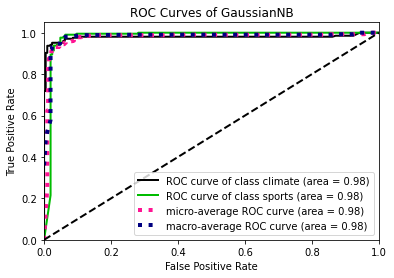

In [172]:
from sklearn.naive_bayes import GaussianNB
GNB_clf = GaussianNB()
GNB_clf.fit(reduced_train_matrix, train_labels)

GNB_prediction = GNB_clf.predict(reduced_test_matrix)
predict_proba = GNB_clf.predict_proba(reduced_test_matrix)

skplt.metrics.plot_roc(test_labels, predict_proba, title='ROC Curves of GaussianNB')
plt.show()

In [173]:
confusion_matrix_GNB = metrics.confusion_matrix(y_true=test_labels, y_pred=GNB_prediction, labels=['sports', 'climate'])
print("The confusion matrix of GNB classifier is as following:")
print(confusion_matrix_GNB)

accuracy = accuracy_score(test_labels, GNB_prediction)
precision = precision_score(test_labels, GNB_prediction, average='macro')
recall = recall_score(test_labels, GNB_prediction, average='macro')
f1 = f1_score(test_labels, GNB_prediction, average='macro')
print("Precision of GNB classifier is {}".format(precision))
print("Recall of GNB classifier is {}".format(recall))
print("F1-Score of GNB classifier is {}".format(f1))
print("Accuracy of GNB classifier is {}".format(accuracy))

The confusion matrix of GNB classifier is as following:
[[191  18]
 [  6 200]]
Precision of GNB classifier is 0.9434871699343361
Recall of GNB classifier is 0.9423746922469457
F1-Score of GNB classifier is 0.9421414629612418
Accuracy of GNB classifier is 0.9421686746987952


## Grid Search of Parameters

### Question 8

In [183]:
from nltk.stem.porter import *

def get_vocab(texts, clean_flag, min_df, compression_method):
    clean_texts = []
    if not clean_flag:
        clean_texts = texts
    clean_texts = [clean(text) for text in texts]
    vectorizer = CountVectorizer(min_df=min_df, stop_words='english')
    vectorizer.fit(clean_texts)
    tokens = vectorizer.get_feature_names_out()
    
    if compression_method == 'none': return tokens
    elif compression_method == 'lemmatize':
        pos_tags = nltk.pos_tag(tokens)
        wnl = WordNetLemmatizer()
        vocab = [wnl.lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
        return list(set(vocab))
    elif compression_method == 'stem':
        stemmer = PorterStemmer()
        vocab = [stemmer.stem(token) for token in tokens]
        return list(set(vocab))
    else:
        raise ValueError("Wrong compression method. Use 'lemmatize', 'stem' or 'none'.")

VOCAB_LIST = []
VOCAB_LIST.append(get_vocab(train_texts, True, 3, 'lemmatize'))
VOCAB_LIST.append(get_vocab(train_texts, True, 3, 'stem'))
VOCAB_LIST.append(get_vocab(train_texts, True, 3, 'none'))



VOCAB_LIST.append(get_vocab(train_texts, True, 5, 'lemmatize'))
VOCAB_LIST.append(get_vocab(train_texts, True, 5, 'stem'))
VOCAB_LIST.append(get_vocab(train_texts, True, 5, 'none'))

VOCAB_LIST.append(get_vocab(train_texts, False, 3, 'lemmatize'))
VOCAB_LIST.append(get_vocab(train_texts, False, 3, 'stem'))
VOCAB_LIST.append(get_vocab(train_texts, False, 3, 'none'))

VOCAB_LIST.append(get_vocab(train_texts, False, 5, 'lemmatize'))
VOCAB_LIST.append(get_vocab(train_texts, False, 5, 'stem'))
VOCAB_LIST.append(get_vocab(train_texts, False, 5, 'none'))


        
print("Vocab list completed")

Vocab list completed


In [177]:
from joblib import Memory
from shutil import rmtree
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2

location = "D:\\cache"
memory = Memory(location=location)
pipe = Pipeline(
    [
        ('count', CountVectorizer()),
        ('tfid', TfidfTransformer()),
        ("reduce_dim", "passthrough"),
        ("classify", "passthrough"),
    ],
    memory=memory
)

N_COMPONENTS_OPTIONS = [5, 50]
CLASSIFIERS = [
    SVC(kernel='linear', C=best_y, probability=True),
    LogisticRegression(solver='liblinear', penalty='l1', C=1/best_l1),
    LogisticRegression(solver='liblinear', penalty='l2', C=1/best_l2),
    GaussianNB()
]
param_grid = [
    {
        "count__vocabulary": VOCAB_LIST,
        "reduce_dim": [TruncatedSVD(), NMF()],
        "reduce_dim__n_components": N_COMPONENTS_OPTIONS,
        "classify": CLASSIFIERS
    },
  
]


In [178]:
grid = GridSearchCV(pipe, n_jobs=-1, param_grid=param_grid, scoring="accuracy")
grid.fit(train_texts, train_labels)
print("done!")

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=5), <1326x9693 sparse matrix of type '<class 'numpy.float64'>'
	with 145443 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sport

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________fit_transform_one - 0.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=50), <1325x9693 sparse matrix of type '<class 'numpy.float64'>'
	with 144687 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=50), <1326x9693 sparse matrix of type '<class 'numpy.float64'>'
	with 145368 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'spor

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


_______________________________________________fit_transform_one - 14.9s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=50), <1326x9693 sparse matrix of type '<class 'numpy.float64'>'
	with 145443 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


_______________________________________________fit_transform_one - 24.1s, 0.4min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(vocabulary=['cove', 'isabel', 'extens', 'peopl', 'spasski',
                            'endur', 'pit', 'na', 'martial', 'ethiopia',
                            'linda', 'reuter', 'nj', 'product', 'prudent',
                            'syrian', 'valiant', 'heel', 'lithuania', 'cagr',
                            'rail', 'soggi', 'term', 'clone', 'bluff',
                            'grammywin', 'fund', 'unmistak', 'travi', 'alcohol', ...]), 
1782    "Pages of history" features excerpts from The ...
1909    Weather Rain Saturday Will Help With Symptoms ...
1920    Will the serious drought conditions afflicting...
1005    In addition to the new desktop interface, Micr...
1538    A major storm system has brought heavy rain an...
           

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


_______________________________________________fit_transform_one - 36.8s, 0.6min
________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50), <1326x8444 sparse matrix of type '<class 'numpy.float64'>'
	with 105359 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
 

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________fit_transform_one - 1.4s, 0.0min
________________________________________________fit_transform_one - 0.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=5), <1325x8444 sparse matrix of type '<class 'numpy.float64'>'
	with 104496 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate'

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=5), <1326x8444 sparse matrix of type '<class 'numpy.float64'>'
	with 102800 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  '

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________fit_transform_one - 0.9s, 0.0min
________________________________________________fit_transform_one - 0.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=5), <1326x8444 sparse matrix of type '<class 'numpy.float64'>'
	with 105557 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate'

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=50), <1325x8444 sparse matrix of type '<class 'numpy.float64'>'
	with 105264 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________fit_transform_one - 1.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=50), <1326x8444 sparse matrix of type '<class 'numpy.float64'>'
	with 102800 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=50), <1326x8444 sparse matrix of type '<class 'numpy.float64'>'
	with 105359 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'spor

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


_______________________________________________fit_transform_one - 13.1s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=50), <1326x8444 sparse matrix of type '<class 'numpy.float64'>'
	with 105557 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


_______________________________________________fit_transform_one - 16.8s, 0.3min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(vocabulary=array(['aap', ..., 'zurich'], dtype=object)), 1782    "Pages of history" features excerpts from The ...
1909    Weather Rain Saturday Will Help With Symptoms ...
1920    Will the serious drought conditions afflicting...
1005    In addition to the new desktop interface, Micr...
1538    A major storm system has brought heavy rain an...
                              ...                        
1638    The redesigned Ford Ranger made its debut on W...
1095    (Newser) – A family that died on a hike in Cal...
1130    --News Direct--\n\nPano AI , the leader in wil...
1294    EAST TAWAS, Mich. – The public is invited to a...
860     If there’s a central theme to Edgar Wright’s n...
Name: full_text, Length: 1325, dtype: object, 
[ 'cl

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/pipeline.py:348: UserWarning: Persisting input arguments took 0.63s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <1325x12905 sparse matrix of type '<class 'numpy.int64'>'
	with 189799 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sport..

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/pipeline.py:348: UserWarning: Persisting input arguments took 0.64s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


________________________________________________fit_transform_one - 3.0s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <1326x12905 sparse matrix of type '<class 'numpy.int64'>'
	with 186119 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'cl

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/pipeline.py:348: UserWarning: Persisting input arguments took 0.78s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


________________________________________________fit_transform_one - 2.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <1326x12905 sparse matrix of type '<class 'numpy.int64'>'
	with 191107 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'cl

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=5), <1325x12905 sparse matrix of type '<class 'numpy.float64'>'
	with 189799 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'spor

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________fit_transform_one - 1.7s, 0.0min
________________________________________________fit_transform_one - 0.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=5), <1326x12905 sparse matrix of type '<class 'numpy.float64'>'
	with 186119 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=5), <1326x12905 sparse matrix of type '<class 'numpy.float64'>'
	with 190630 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'spor

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=5), <1326x12905 sparse matrix of type '<class 'numpy.float64'>'
	with 191107 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'spor

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________fit_transform_one - 0.8s, 0.0min


/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


________________________________________________fit_transform_one - 0.7s, 0.0min
_______________________________________________fit_transform_one - 28.7s, 0.5min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=50), <1325x12905 sparse matrix of type '<class 'numpy.float64'>'
	with 191549 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',


/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=50), <1325x12905 sparse matrix of type '<class 'numpy.float64'>'
	with 189799 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'spo

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=50), <1326x12905 sparse matrix of type '<class 'numpy.float64'>'
	with 186119 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'spo

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=50), <1326x12905 sparse matrix of type '<class 'numpy.float64'>'
	with 190630 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'spo

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


_______________________________________________fit_transform_one - 21.7s, 0.4min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=50), <1326x12905 sparse matrix of type '<class 'numpy.float64'>'
	with 191107 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
 

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


_______________________________________________fit_transform_one - 24.5s, 0.4min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(vocabulary=['disciplinary', 'singlefamily', 'attendance',
                            'fishing', 'na', 'martial', 'sars', 'ethiopia',
                            'nj', 'product', 'voice', 'syrian', 'accordance',
                            'advertiser', 'anticipation', 'lithuania', 'cagr',
                            'mining', 'noticed', 'rail', 'term', 'integrity',
                            'eligible', 'fund', 'pending', 'faeroe', 'ensue',
                            'alcohol', 'custody', 'interim', ...]), 
1782    "Pages of history" features excerpts from The ...
1909    Weather Rain Saturday Will Help With Symptoms ...
1920    Will the serious drought conditions afflicting...
1005    In addition to the new desktop interface, Micr...

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/pipeline.py:348: UserWarning: Persisting input arguments took 0.51s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


________________________________________________fit_transform_one - 2.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <1325x6479 sparse matrix of type '<class 'numpy.int64'>'
	with 136799 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'cli

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/pipeline.py:348: UserWarning: Persisting input arguments took 0.57s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


________________________________________________fit_transform_one - 0.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <1326x6479 sparse matrix of type '<class 'numpy.int64'>'
	with 137734 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'cli

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/pipeline.py:348: UserWarning: Persisting input arguments took 0.53s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=5), <1326x6479 sparse matrix of type '<class 'numpy.float64'>'
	with 137496 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=5), <1325x6479 sparse matrix of type '<class 'numpy.float64'>'
	with 136799 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  '

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=5), <1326x6479 sparse matrix of type '<class 'numpy.float64'>'
	with 137734 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sport

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________fit_transform_one - 1.5s, 0.0min
________________________________________________fit_transform_one - 1.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=5), <1326x6479 sparse matrix of type '<class 'numpy.float64'>'
	with 137496 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate'

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=50), <1325x6479 sparse matrix of type '<class 'numpy.float64'>'
	with 137986 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=50), <1325x6479 sparse matrix of type '<class 'numpy.float64'>'
	with 136799 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'spor

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=50), <1326x6479 sparse matrix of type '<class 'numpy.float64'>'
	with 134273 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'spor

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


_______________________________________________fit_transform_one - 31.4s, 0.5min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=50), <1326x6479 sparse matrix of type '<class 'numpy.float64'>'
	with 137734 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________fit_transform_one - 9.9s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=50), <1326x6479 sparse matrix of type '<class 'numpy.float64'>'
	with 137496 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


_______________________________________________fit_transform_one - 17.2s, 0.3min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(vocabulary=['extens', 'peopl', 'endur', 'na', 'martial',
                            'ethiopia', 'reuter', 'nj', 'product', 'syrian',
                            'lithuania', 'cagr', 'rail', 'soggi', 'term',
                            'fund', 'travi', 'alcohol', 'cultur', 'uptod',
                            'interim', 'path', 'kilomet',
                            'carlsennepomniachtchi', 'gameplay', 'surround',
                            'attitud', 'cal', 'drizzl', 'medic', ...]), 
1782    "Pages of history" features excerpts from The ...
1909    Weather Rain Saturday Will Help With Symptoms ...
1920    Will the serious drought conditions afflicting...
1005    In addition to the new desktop interface, Micr...
1538    A major storm sy

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/pipeline.py:348: UserWarning: Persisting input arguments took 0.52s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


________________________________________________fit_transform_one - 2.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <1326x5652 sparse matrix of type '<class 'numpy.int64'>'
	with 100084 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'cli

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


_______________________________________________fit_transform_one - 27.5s, 0.5min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=50), <1326x5652 sparse matrix of type '<class 'numpy.float64'>'
	with 97573 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'clim

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=5), <1325x5652 sparse matrix of type '<class 'numpy.float64'>'
	with 99112 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=5), <1326x5652 sparse matrix of type '<class 'numpy.float64'>'
	with 100084 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sport

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________fit_transform_one - 0.6s, 0.0min
________________________________________________fit_transform_one - 0.6s, 0.0min
________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________fit_transform_one - 0.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=50), <1325x5652 sparse matrix of type '<class 'numpy.float64'>'
	with 99934 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
 

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=50), <1326x5652 sparse matrix of type '<class 'numpy.float64'>'
	with 97573 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sport

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=50), <1326x5652 sparse matrix of type '<class 'numpy.float64'>'
	with 100081 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'spor

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________fit_transform_one - 8.5s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=50), <1326x5652 sparse matrix of type '<class 'numpy.float64'>'
	with 100084 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


_______________________________________________fit_transform_one - 13.8s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(vocabulary=array(['aaron', ..., 'zurich'], dtype=object)), 1782    "Pages of history" features excerpts from The ...
1909    Weather Rain Saturday Will Help With Symptoms ...
1920    Will the serious drought conditions afflicting...
1005    In addition to the new desktop interface, Micr...
1538    A major storm system has brought heavy rain an...
                              ...                        
1638    The redesigned Ford Ranger made its debut on W...
1095    (Newser) – A family that died on a hike in Cal...
1130    --News Direct--\n\nPano AI , the leader in wil...
1294    EAST TAWAS, Mich. – The public is invited to a...
860     If there’s a central theme to Edgar Wright’s n...
Name: full_text, Length: 1325, dtype: object, 
[ '

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/pipeline.py:348: UserWarning: Persisting input arguments took 0.58s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


________________________________________________fit_transform_one - 3.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <1325x8696 sparse matrix of type '<class 'numpy.int64'>'
	with 180846 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/pipeline.py:348: UserWarning: Persisting input arguments took 0.56s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <1325x8696 sparse matrix of type '<class 'numpy.int64'>'
	with 178962 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sport...

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/pipeline.py:348: UserWarning: Persisting input arguments took 0.54s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


________________________________________________fit_transform_one - 2.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <1326x8696 sparse matrix of type '<class 'numpy.int64'>'
	with 175665 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'cli

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/pipeline.py:348: UserWarning: Persisting input arguments took 0.54s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


________________________________________________fit_transform_one - 3.1s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(), <1326x8696 sparse matrix of type '<class 'numpy.int64'>'
	with 180109 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'cli

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=5), <1325x8696 sparse matrix of type '<class 'numpy.float64'>'
	with 178962 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sport

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________fit_transform_one - 0.9s, 0.0min
________________________________________________fit_transform_one - 1.2s, 0.0min
________________________________________________fit_transform_one - 0.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=5), <1326x8696 sparse matrix of type '<class 'numpy.float64'>'
	with 175665 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'clim

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=5), <1326x8696 sparse matrix of type '<class 'numpy.float64'>'
	with 180109 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sport

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________fit_transform_one - 0.8s, 0.0min
________________________________________________fit_transform_one - 0.8s, 0.0min
________________________________________________fit_transform_one - 0.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=50), <1325x8696 sparse matrix of type '<class 'numpy.float64'>'
	with 178962 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'cli

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=50), <1326x8696 sparse matrix of type '<class 'numpy.float64'>'
	with 180202 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'spor

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


_______________________________________________fit_transform_one - 21.8s, 0.4min
_______________________________________________fit_transform_one - 21.6s, 0.4min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(n_components=50), <1326x8696 sparse matrix of type '<class 'numpy.float64'>'
	with 180109 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


_______________________________________________fit_transform_one - 29.5s, 0.5min
_______________________________________________fit_transform_one - 33.4s, 0.6min
_______________________________________________fit_transform_one - 10.0s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(vocabulary=array(['aap', ..., 'zurich'], dtype=object)), 1431    More than 1 million Washingtonians participate...
1567    A 4.7-magnitude earthquake rattled northwest S...
1044    More campgrounds are coming to the Auburn Stat...
175     Retro gamers will be able to relive all the jo...
1610    SAN SIMEON, Calif. (KGTV) — An earthquake with...
                              ...                        
1638    The redesigned Ford Ranger made its debut on W...
1095    (Newser) – A family that died on a hike in Cal...
1130    --News Direct--\n\nPano AI , the leader in wil...
1294  

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________fit_transform_one - 7.7s, 0.1min
done!


In [179]:
from sklearn.model_selection import RandomizedSearchCV
param_grid_randCV = {
        "count__vocabulary": VOCAB_LIST,
        "reduce_dim": [TruncatedSVD(), NMF(tol=0.05, max_iter=50)],
        "reduce_dim__n_components": [500],
        "classify": CLASSIFIERS
    }
randCV = RandomizedSearchCV(pipe, n_jobs=-1, param_distributions=param_grid_randCV, scoring="accuracy")
randCV.fit(train_texts, train_labels)
memory.clear(warn=False)
rmtree(location)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=500), <1326x9693 sparse matrix of type '<class 'numpy.float64'>'
	with 141852 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(max_iter=50, n_components=500, tol=0.05), <1325x5652 sparse matrix of type '<class 'numpy.float64'>'
	with 99112 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climat

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


_______________________________________________fit_transform_one - 12.3s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(max_iter=50, n_components=500, tol=0.05), <1326x5652 sparse matrix of type '<class 'numpy.float64'>'
	with 100081 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  '

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


_______________________________________________fit_transform_one - 38.3s, 0.6min
_______________________________________________fit_transform_one - 37.9s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(max_iter=50, n_components=500, tol=0.05), <1326x5652 sparse matrix of type '<class 'numpy.float64'>'
	with 100084 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=500), <1325x8444 sparse matrix of type '<class 'numpy.float64'>'
	with 105264 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'cl

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/pipeline.py:348: UserWarning: Persisting input arguments took 0.63s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


_______________________________________________fit_transform_one - 10.8s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=500), <1326x8444 sparse matrix of type '<class 'numpy.float64'>'
	with 105359 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'cl

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/pipeline.py:348: UserWarning: Persisting input arguments took 0.51s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


_______________________________________________fit_transform_one - 15.3s, 0.3min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=500), <1326x8444 sparse matrix of type '<class 'numpy.float64'>'
	with 105557 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'cl

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________fit_transform_one - 9.8s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(max_iter=50, n_components=500, tol=0.05), <1325x8444 sparse matrix of type '<class 'numpy.float64'>'
	with 104496 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  '

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


_______________________________________________fit_transform_one - 70.9s, 1.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(max_iter=50, n_components=500, tol=0.05), <1326x8444 sparse matrix of type '<class 'numpy.float64'>'
	with 102800 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  '

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


_______________________________________________fit_transform_one - 37.2s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(max_iter=50, n_components=500, tol=0.05), <1326x8444 sparse matrix of type '<class 'numpy.float64'>'
	with 105359 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  '

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


_______________________________________________fit_transform_one - 57.9s, 1.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(max_iter=50, n_components=500, tol=0.05), <1326x8444 sparse matrix of type '<class 'numpy.float64'>'
	with 105557 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  '

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


_______________________________________________fit_transform_one - 50.1s, 0.8min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=500), <1325x5652 sparse matrix of type '<class 'numpy.float64'>'
	with 99934 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________fit_transform_one - 6.6s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(max_iter=50, n_components=500, tol=0.05), <1325x8696 sparse matrix of type '<class 'numpy.float64'>'
	with 180846 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'sport

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(max_iter=50, n_components=500, tol=0.05), <1325x8696 sparse matrix of type '<class 'numpy.float64'>'
	with 178962 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'clima

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 50 reached. Increase it to improve convergence.
  warnings.warn(


______________________________________________fit_transform_one - 249.5s, 4.2min
_______________________________________________fit_transform_one - 40.9s, 0.7min
_______________________________________________fit_transform_one - 49.9s, 0.8min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(max_iter=50, n_components=500, tol=0.05), <1326x8696 sparse matrix of type '<class 'numpy.float64'>'
	with 175665 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'clima

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(max_iter=50, n_components=500, tol=0.05), <1326x8696 sparse matrix of type '<class 'numpy.float64'>'
	with 180202 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'clima

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(max_iter=50, n_components=500, tol=0.05), <1326x8696 sparse matrix of type '<class 'numpy.float64'>'
	with 180109 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'climate',
  'climate',
  'sports',
  'clima

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


_______________________________________________fit_transform_one - 56.1s, 0.9min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=500), <1325x6479 sparse matrix of type '<class 'numpy.float64'>'
	with 137986 stored elements in Compressed Sparse Row format>, 
[ 'climate',
  'climate',
  'climate',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'climate',
  'sports',
  'sports',
  'sports',
  'climate',
  'climate',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports',
  'sports',
  'climate',
  'sports',
  'climate',
  'sports',
  'sports'

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 50 reached. Increase it to improve convergence.
  warnings.warn(


______________________________________________fit_transform_one - 192.2s, 3.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(vocabulary=['cove', 'disciplinary', 'isabel', 'singlefamily',
                            'selfies', 'sharmas', 'pit', 'attendance',
                            'fishing', 'na', 'martial', 'sars', 'bayside',
                            'ethiopia', 'linda', 'nj', 'product', 'voice',
                            'prudent', 'staple', 'syrian', 'accordance',
                            'advertiser', 'anticipation', 'heel', 'valiant',
                            'lithuania', 'cagr', 'mining', 'rail', ...]), 
1431    More than 1 million Washingtonians participate...
1567    A 4.7-magnitude earthquake rattled northwest S...
1044    More campgrounds are coming to the Auburn Stat...
175     Retro gamers will be able to relive all the jo...
1610   

In [191]:
import pandas as pd
results = pd.DataFrame(grid.cv_results_)
results = results.sort_values(by=['rank_test_score'])

display(results.head(5)) 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classify,param_count__vocabulary,param_reduce_dim,param_reduce_dim__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
131,0.481830,0.041412,0.505436,0.054166,"LogisticRegression(C=100.0, solver='liblinear')","[aap, aaron, ab, abandon, abandoned, abandonin...",NMF(n_components=50),50,"{'classify': LogisticRegression(C=100.0, solve...",0.966867,0.960843,0.966767,0.951662,0.969789,0.963186,0.006454,1
107,0.426422,0.017641,0.470146,0.026536,"LogisticRegression(C=100.0, solver='liblinear')","[aap, aaron, ab, abandon, abandoned, abandonin...",NMF(n_components=50),50,"{'classify': LogisticRegression(C=100.0, solve...",0.966867,0.960843,0.966767,0.951662,0.969789,0.963186,0.006454,1
59,0.521790,0.059376,0.533789,0.058172,"LogisticRegression(C=10.0, penalty='l1', solve...","[aap, aaron, ab, abandon, abandoned, abandonin...",NMF(n_components=50),50,"{'classify': LogisticRegression(C=10.0, penalt...",0.966867,0.954819,0.966767,0.960725,0.960725,0.961981,0.004500,3
83,0.456916,0.007035,0.468202,0.021703,"LogisticRegression(C=10.0, penalty='l1', solve...","[aap, aaron, ab, abandon, abandoned, abandonin...",NMF(n_components=50),50,"{'classify': LogisticRegression(C=10.0, penalt...",0.966867,0.954819,0.966767,0.960725,0.960725,0.961981,0.004500,3
33,0.633399,0.028247,0.368670,0.021953,"SVC(C=100, kernel='linear', probability=True)","[aap, aaron, ab, abandon, abandoned, abandonin...",TruncatedSVD(),50,"{'classify': SVC(C=100, kernel='linear', proba...",0.972892,0.957831,0.951662,0.957704,0.969789,0.961975,0.008025,5


In [189]:
import pandas as pd
results = pd.DataFrame(randCV.cv_results_)
results = results.sort_values(by=['rank_test_score'])

display(results.head(5))
print(results.head(5)['param_classify'][0])


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reduce_dim__n_components,param_reduce_dim,param_count__vocabulary,param_classify,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,17.592843,1.992183,0.589080,0.272077,500,TruncatedSVD(n_components=500),"[cove, disciplinary, isabel, singlefamily, sel...","LogisticRegression(C=10.0, penalty='l1', solve...","{'reduce_dim__n_components': 500, 'reduce_dim'...",0.984940,0.984940,0.957704,0.969789,0.969789,0.973432,0.010381,1
4,8.966577,0.389972,0.520992,0.098104,500,TruncatedSVD(n_components=500),"[extens, peopl, endur, na, martial, ethiopia, ...","SVC(C=100, kernel='linear', probability=True)","{'reduce_dim__n_components': 500, 'reduce_dim'...",0.972892,0.975904,0.951662,0.957704,0.948640,0.961360,0.011079,2
3,51.766108,6.861621,2.570096,0.316104,500,"NMF(max_iter=50, tol=0.05)","[cove, isabel, extens, peopl, spasski, endur, ...","SVC(C=100, kernel='linear', probability=True)","{'reduce_dim__n_components': 500, 'reduce_dim'...",0.969880,0.945783,0.957704,0.957704,0.948640,0.955942,0.008450,3
9,0.455110,0.018364,2.142411,0.300483,500,"NMF(max_iter=50, tol=0.05)","[cove, isabel, extens, peopl, spasski, endur, ...",GaussianNB(),"{'reduce_dim__n_components': 500, 'reduce_dim'...",0.948795,0.978916,0.945619,0.960725,0.942598,0.955331,0.013300,4
5,10.389541,19.971291,2.626794,0.435078,500,"NMF(max_iter=50, tol=0.05)","[extens, peopl, endur, na, martial, ethiopia, ...","LogisticRegression(C=10.0, penalty='l1', solve...","{'reduce_dim__n_components': 500, 'reduce_dim'...",0.942771,0.951807,0.930514,0.948640,0.954683,0.945683,0.008554,5


LogisticRegression(C=10.0, penalty='l1', solver='liblinear')


The 5 best combinations would be 

        1. With cleaning, min_df = 3, lemmatization, LSI with k = 500,  LogisticRegression(C=10.0, penalty='l1', solver='liblinear') with accuracy 0.973432
        2. With cleaning, min_df = 3, nothing neither lemmatization nor stemming, NMF(n_components=50), LogisticRegression(C=100.0, solver='liblinear') with accuracy 0.963186
        3. With cleaning, min_df = 3, nothing neither lemmatization nor stemming, NMF(n_components=50), LogisticRegression(C=10.0, penalty='l1', solver='liblinear') with accuracy 0.961981
        4. With cleaning, min_df = 5, stem, LSI with k = 500, SVC(C=100, kernel='linear', probability=True) with accuracy 0.961360
        5. With cleaning, min_df = 3, nothing neither lemmatization nor stemming, LSI with k = 500, SVC(C=100, kernel='linear', probability=True) with accuracy 0.961975

## Multiclass Classification

### Question 9

##### Part 0. How did you resolve the class imbalance issue in the one Vs the rest model?

We set the class_weight to balanced in the SVC() used in the one vs the rest model to resolve the class imbalance issue in the One vs Rest model. By adding this parameter, the SVC will automatically assign class weight inversely proportional to the frequency of the certain classes. Minority classes will have higher weight than the majority classes. One vs the rest involves splitting the entire problem into multiple binary classification problems and each of the binary classifier is trained on each of the binary classifier problem. Because it has more number of classifiers than the other model, it has more numbers of estimator and thus a better result.

In [192]:
y_train = list(train["leaf_label"])
y_test = list(test["leaf_label"])

reduced_train_matrix_for_test = reduced_train_matrix
reduced_test_matrix_for_test = reduced_test_matrix

##### Part 1 Do you observe any structure in the confusion matrix? Are there distinct visible blocks on the major diagonal? What does this mean?

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


The following is the evaluation of Multinomial NB
confusion matrix:
[[46  0  0  0  0  0  0  0]
 [ 3 46  0  0  0  0  0  1]
 [10  1 45  2  0  0  0  0]
 [ 5  0  0 50  0  0  0  0]
 [ 5  0  1  0 43  0  0  0]
 [ 6  0  0  0  2 37  6  2]
 [12  0  1  1  0  1 41  1]
 [ 5  0  1  0  3  0  0 38]]
accuracy 0.8337349397590361
precision 0.8757799381029854
recall 0.8385532612404583
f1_score 0.841535209834493


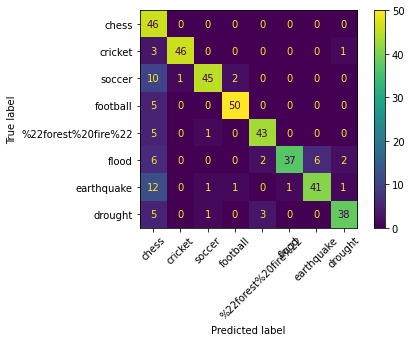

In [193]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score


labels = ['chess', 'cricket', 'soccer', 'football', '%22forest%20fire%22', 'flood', 'earthquake', 'drought']

MTNB_clf = Pipeline([('Normalizing', MinMaxScaler()),('MultinomialNB', MultinomialNB())]).fit(reduced_train_matrix, y_train)

y_pred = MTNB_clf.predict(reduced_test_matrix)

confusion_matrix_naive_bayes = metrics.confusion_matrix(y_test, y_pred, labels=labels)
plot_confusion_matrix(MTNB_clf, reduced_test_matrix, y_test, labels=labels) 
plt.xticks(rotation = 45) 
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1_score = f1_score(y_test, y_pred, average='macro')

print("The following is the evaluation of Multinomial NB")
print("confusion matrix:")
print(confusion_matrix_naive_bayes)
print("accuracy", accuracy)
print("precision", precision)
print("recall", recall)
print("f1_score", f1_score)


/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


The following is the evaluation of One VS One SVM
confusion matrix of:
[[44  0  0  1  0  0  1  0]
 [ 0 49  0  0  0  0  0  1]
 [ 7  1 50  0  0  0  0  0]
 [ 3  0  0 52  0  0  0  0]
 [ 2  0  1  0 46  0  0  0]
 [ 3  0  0  1  2 43  2  2]
 [ 3  0  1  1  0  2 49  1]
 [ 3  0  1  0  0  1  0 42]]
accuracy 0.9036144578313253
precision 0.911780120173783
recall 0.9059259573883622
f1_score 0.9048246364176853


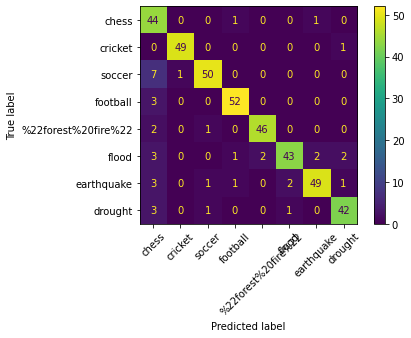

In [194]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
# ['chess', 'cricket', 'soccer', 'football', '%22forest%20fire%22', 'flood', 'earthquake', 'drought']

clf = OneVsOneClassifier(LinearSVC(random_state=0)).fit(reduced_train_matrix, y_train)
y_pred = clf.predict(reduced_test_matrix)
confusion_matrix_one_vs_one = metrics.confusion_matrix(y_test, y_pred, labels=labels)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1_score = f1_score(y_test, y_pred, average='macro')

plot_confusion_matrix(clf, reduced_test_matrix, y_test, labels=labels) 
plt.xticks(rotation = 45) 

print("The following is the evaluation of One VS One SVM")
print("confusion matrix of:")
print(confusion_matrix_one_vs_one)
print("accuracy", accuracy)
print("precision", precision)
print("recall", recall)
print("f1_score", f1_score)

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


The following is the evaluation of One VS Rest SVM
confusion matrix:
[[44  0  1  0  0  0  1  0]
 [ 0 49  0  0  0  0  0  1]
 [ 4  1 53  0  0  0  0  0]
 [ 2  0  1 52  0  0  0  0]
 [ 1  0  1  0 46  0  1  0]
 [ 2  0  1  0  2 44  2  2]
 [ 1  0  1  1  0  1 52  1]
 [ 3  1  1  0  0  0  0 42]]
accuracy 0.9204819277108434
precision 0.9237346645559705
recall 0.9213289125642002
f1_score 0.920450551420133


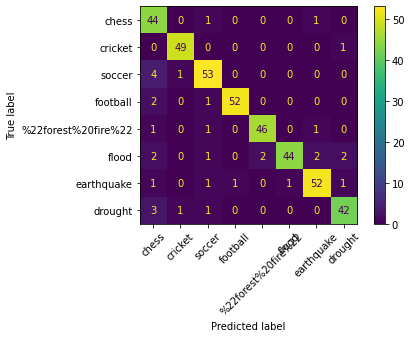

In [195]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score

clf = OneVsRestClassifier(SVC(class_weight='balanced')).fit(reduced_train_matrix, y_train)
y_pred = clf.predict(reduced_test_matrix)
confusion_matrix_one_vs_rest = metrics.confusion_matrix(y_test, y_pred, labels=labels)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1_score = f1_score(y_test, y_pred, average='macro')

plot_confusion_matrix(clf, reduced_test_matrix, y_test, labels=labels) 
plt.xticks(rotation = 45) 

print("The following is the evaluation of One VS Rest SVM")
print("confusion matrix:")
print(confusion_matrix_one_vs_rest)
print("accuracy", accuracy)
print("precision", precision)
print("recall", recall)
print("f1_score", f1_score)


We observe that the main diagonal of the confusion matrix stands out among the other blocks. We can also observe the distinct visible blocks on the first column of the confusion matrices generated for the three different classifiers: Naive Bayes, One vs One, and One vs Rest. That implies that for the first label "chess", the prediction model for this label will have a high error rate as it can basically mislabel the other labels as "chess", as we can see from the numbers on the first column.

##### Part 2 Based on your observation from the previous part, suggest a subset of labels that should be merged into a new larger label and recompute the accuracy and plot the confusion matrix. How did the accuracy change in One vS One and One VS the rest?

In [196]:
labels = ['chess', 'cricket', 'balls' ,'%22forest%20fire%22', 'flood', 'earthquake', 'drought']
# labels = ['chess', 'cricket', 'soccer', 'football', '%22forest%20fire%22', 'flood', 'earthquake', 'drought']

train_index = []
test_index = []
ctn1 = 0
ctn2 = 0

for i in range(len(y_train)):
    if y_train[i] == "football" or y_train[i] == "soccer":
        train_index.append(i)
        y_train[i] = "balls"
    if y_train[i] == "chess":
        ctn1+=1

for i in range(len(y_test)):
    if y_test[i] == "football" or y_test[i] == "soccer":
        test_index.append(i)
        y_test[i] = "balls"
    if y_test[i] == "chess":
        ctn2+=1




print(ctn1, ctn2)
print(y_train.count("balls"))


213 46
405


/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


confusion matrix:
[[ 44   0   1   0   0   1   0]
 [  0  48   1   0   0   0   1]
 [  5   1 107   0   0   0   0]
 [  2   0   1  46   0   0   0]
 [  3   0   1   2  43   2   2]
 [  3   0   2   0   2  49   1]
 [  3   0   1   0   1   0  42]]
accuracy 0.9132530120481928
precision 0.9142841105562349
recall 0.9095409718574808
f1_score 0.9088665398097907


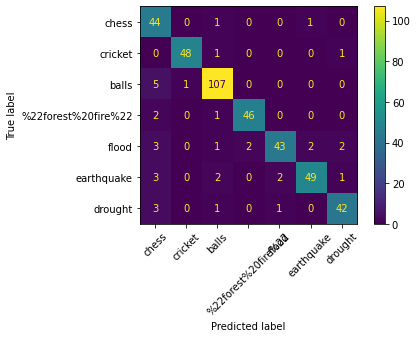

In [197]:
from sklearn.metrics import f1_score
clf = OneVsOneClassifier(LinearSVC(random_state=0)).fit(reduced_train_matrix, y_train)
y_pred = clf.predict(reduced_test_matrix)
confusion_matrix_one_vs_one = metrics.confusion_matrix(y_test, y_pred, labels=labels)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1_score = f1_score(y_test, y_pred, average='macro')

plot_confusion_matrix(clf, reduced_test_matrix, y_test, labels=labels) 
plt.xticks(rotation = 45) 

print("confusion matrix:")
print(confusion_matrix_one_vs_one)
print("accuracy", accuracy)
print("precision", precision)
print("recall", recall)
print("f1_score", f1_score)

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


confusion matrix:
[[ 44   0   1   0   0   1   0]
 [  0  49   0   0   0   0   1]
 [  5   2 106   0   0   0   0]
 [  1   0   1  46   0   1   0]
 [  2   0   1   2  44   2   2]
 [  1   0   2   0   1  52   1]
 [  3   1   1   0   0   0  42]]
accuracy 0.9228915662650602
precision 0.9217395096277083
recall 0.921348106993702
f1_score 0.9193920306657597


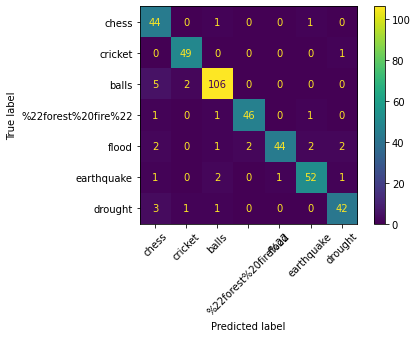

In [198]:
from sklearn.metrics import f1_score

clf = OneVsRestClassifier(SVC(class_weight='balanced')).fit(reduced_train_matrix, y_train)
y_pred = clf.predict(reduced_test_matrix)
confusion_matrix_one_vs_rest = metrics.confusion_matrix(y_test, y_pred, labels=labels)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1_score = f1_score(y_test, y_pred, average='macro')

plot_confusion_matrix(clf, reduced_test_matrix, y_test, labels=labels) 
plt.xticks(rotation = 45) 

print("confusion matrix:")
print(confusion_matrix_one_vs_rest)
print("accuracy", accuracy)
print("precision", precision)
print("recall", recall)
print("f1_score", f1_score)


Based on our observation from the confusion matrices, we grouped the sublabels "soccer" and "football" into one label "balls" and recomputed both classifiers. We observe the improved higher accuracy in both the One vs One and One vs Rest classifiers, which makes sense as by combining the label classes we are helping the classifiers' performance.

##### Part 3. Does class imbalance impact the performance of the classification once some classes are merged? Provide a resolution for the class imbalance and recompute the accuracy and plot the confusion matrix.

In [199]:
new_train_index = []
new_test_index = []
for i in range(200):
    y_train.remove('balls')
    new_train_index.append(train_index[i])
    
reduced_train_matrix_for_test = np.delete(reduced_train_matrix_for_test, new_train_index, axis=0) 
for i in range(50):
    y_test.remove('balls')
    new_test_index.append(test_index[i])

reduced_test_matrix_for_test = np.delete(reduced_test_matrix_for_test, new_test_index, axis=0) 

print(len(y_train), len(y_test))
print(len(reduced_train_matrix_for_test), len(reduced_test_matrix_for_test))


1457 365
1457 365


/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


confusion matrix:
[[44  0  0  1  0  1  0]
 [ 0 49  0  0  0  0  1]
 [ 6  1 56  0  0  0  0]
 [ 2  0  1 46  0  0  0]
 [ 3  0  0  3 43  2  2]
 [ 3  0  2  0  2 49  1]
 [ 3  0  1  0  1  0 42]]
accuracy 0.9013698630136986
precision 0.906396941143912
recall 0.9041104338605714
f1_score 0.9018981693531233


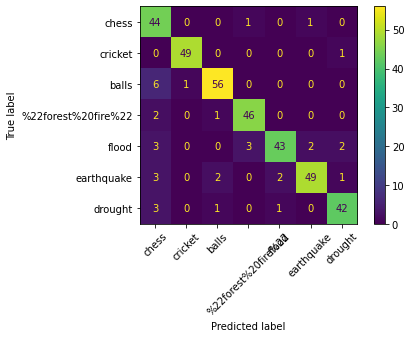

In [201]:
from sklearn.metrics import f1_score

clf = OneVsOneClassifier(LinearSVC(random_state=0)).fit(reduced_train_matrix_for_test, y_train)
y_pred = clf.predict(reduced_test_matrix_for_test)
confusion_matrix_one_vs_one = metrics.confusion_matrix(y_test, y_pred, labels=labels)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1_score = f1_score(y_test, y_pred, average='macro')

plot_confusion_matrix(clf, reduced_test_matrix_for_test, y_test, labels=labels) 
plt.xticks(rotation = 45) 

print("confusion matrix:")
print(confusion_matrix_one_vs_one)
print("accuracy", accuracy)
print("precision", precision)
print("recall", recall)
print("f1_score", f1_score)

/Users/zacyou/Library/Python/3.8/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


confusion matrix:
[[44  1  0  0  0  1  0]
 [ 0 49  0  0  0  0  1]
 [ 7  1 55  0  0  0  0]
 [ 1  0  1 46  0  1  0]
 [ 3  1  0  2 43  2  2]
 [ 1  0  2  0  1 52  1]
 [ 3  1  1  0  0  0 42]]
accuracy 0.9068493150684932
precision 0.9113879101457237
recall 0.9093616571569074
f1_score 0.9071174611687708


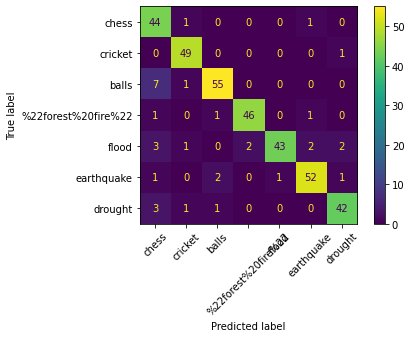

In [202]:
from sklearn.metrics import f1_score

clf = OneVsRestClassifier(SVC(class_weight='balanced')).fit(reduced_train_matrix_for_test, y_train)
y_pred = clf.predict(reduced_test_matrix_for_test)
confusion_matrix_one_vs_rest = metrics.confusion_matrix(y_test, y_pred, labels=labels)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1_score = f1_score(y_test, y_pred, average='macro')

plot_confusion_matrix(clf, reduced_test_matrix_for_test, y_test, labels=labels) 
plt.xticks(rotation = 45) 

print("confusion matrix:")
print(confusion_matrix_one_vs_rest)
print("accuracy", accuracy)
print("precision", precision)
print("recall", recall)
print("f1_score", f1_score)


Yes class imbalance does impact the performance of the classification once some classes are merged. It will result in a higher accuracy. Because the merged class labels have many more datasets than other classes. Having high accuracy caused by imbalanced classes does not mean our classifiers are doing a great job. For instance, a dataset with 90% of data points coming from A and 10% of data points coming from B would yield an accuracy of 90% in predicting A, when in reality it is just the unfair amount of labeling distribution. One solution we proposed was to remove some dataset from the bigger class to match with the size of the rest of classes. From the observation, our classifiers's accuracy decreased a little, which is reasonable as we balanced our classes

## Word Embedding

### Question 10

##### part (a)

Because using only statistical information will fail to capture certain aspects of meaning, for example relevance between words. Models trained solely on probabilities of word distribution perform poorly on word analogy task because it would be affected by the possible noise and make it hard to find the relevant words. In other words, the ratio of co-occurrence probabilities are better for us to separate the groups of contextual words relavant to the target words; if the group of words are more related to the target words in the numerator of the ratio, it will be large and if the group of words are more related to the target words in the numerator of the rator, it will be small, and lastly, if the words are not neither related to the targets words in the denominator nor the numerator, the ratio would just purely be close to 1.

##### part (b)

The vectors in both context would be the same. Because GLoVE is trained on the co-occurrence matrix, which only counts the occurrences of other words in the context of running. In this case, both sentences will be leveraged into the matrix and the model will treat them in the same manner. Therefore, the ultimate word vector of "running" would be the same.

##### part (c)

In [203]:
import numpy as np
embeddings_dict = {}
dimension_of_glove = 300
with open("glove/glove.6B.300d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector
queen = embeddings_dict["queen"]
king = embeddings_dict["king"]
wife = embeddings_dict["wife"]
husband = embeddings_dict["husband"]



In [204]:
e1 = np.linalg.norm(queen-king-wife+husband, ord=2)
e2 = np.linalg.norm(queen-king, ord=2)
e3 = np.linalg.norm(wife-husband, ord=2)
print(e1, e2, e3)

6.1650367 5.966258 3.1520464


The three norms are printed above. To reason about this, we have to keep in mind that GLoVE carries the semantic meaning and relation of words. Intuitively, husband/wife are more closely related than king/queen, as the two pairs are both man/woman and married in this sense, but king/queen also carries the subcontext of royalness. Denote the norm of "queen-king-wife+husband", "queen-king" and "wife-husband" to be e1, e2 and e3, respectively. Therefore, we can infer that husband/wife are closer to each other than king/queen as e3 is smaller than e2. The also explains why e2 is close to e1 because between e3 and e2, e2 is the bigger one; therefore, e2 is naturally closer to the sum of the two vectors represented by e1. 

##### part (d)

We would lemmatize the word, because stem will tend to break the structure of the word and we will not be able to capture its context meaning; on the other hand, lemmatize will compress the word given its position tag which grants us its original meaning. Plus, GLoVE's mapping requires recognizable English words. 

### Question 11

##### part (a)

We can still use the full_text to construct the sentence vectors based on GLoVE embeddings. For a given full text, we add all the GLoVE embeddings of its words and normalize the final vector by its norm. 

##### part (b)

In [205]:
def get_sentence_embeddings(glove_dimension):
    embeddings_dict = {}
    dimension_of_glove = glove_dimension
    with open("glove/glove.6B." + str(glove_dimension) + "d.txt", 'r', encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector

    sentence_representation_train = []
    sentence_representation_test = []

    for text in train_texts:
        cur_vec = np.zeros(dimension_of_glove)
        for word in text.split():
            cur_vec += embeddings_dict.get(word, np.zeros(dimension_of_glove))
        cur_vec /= np.linalg.norm(cur_vec)
        sentence_representation_train.append(cur_vec)
    for text in test_texts:
        cur_vec = np.zeros(dimension_of_glove)
        for word in text.split():
            cur_vec += embeddings_dict.get(word, np.zeros(dimension_of_glove))
        cur_vec /= np.linalg.norm(cur_vec)
        sentence_representation_test.append(cur_vec)

    sentence_representation_train = np.array(sentence_representation_train)
    sentence_representation_test = np.array(sentence_representation_test)
    return sentence_representation_train, sentence_representation_test


In [206]:
from sklearn.svm import SVC

train_sentence_vectors, test_sentence_vectors = get_sentence_embeddings(300)

svc = SVC(kernel='linear', C=best_y, probability=True)
svc.fit(train_sentence_vectors, train_labels)
print(svc.score(test_sentence_vectors, test_labels))

0.9493975903614458


##### Part 1
For each train data, we sum the GLoVE vector of each word in the full text and then normalize it and obtain the new feature vector for each training data. This method follows all the rules mentioned in spec.

##### Part 2
We use SVM with the best gamma value found before on this GLoVE-based feature. The accuracy is pretty good, which is 0.949 as shown above.

### Question 12

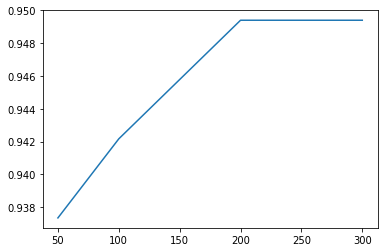

In [207]:
glove_dimensions = [50, 100, 200, 300]
accuracy_list = []
for dimension in glove_dimensions:
    train_sentence_vectors, test_sentence_vectors = get_sentence_embeddings(dimension)
    svc = SVC(kernel='linear', C=best_y, probability=True)
    svc.fit(train_sentence_vectors, train_labels)
    accuracy_list.append(svc.score(test_sentence_vectors, test_labels))
plt.plot(glove_dimensions, accuracy_list)
plt.show()

When the dimension of the GLoVE embedding increases, the accuracy also increases. This trend is expected as a higher dimension of GLoVE may carry more information of individual words, which in term gives more information to the aggregated document vector and facilitates the classification task.

### Question 13

In [208]:
train_sentence_vectors, _ = get_sentence_embeddings(300)

In [209]:
import umap.umap_ as umap
mapper = umap.UMAP().fit(train_sentence_vectors)

# umap.plot.points(mapper, labels=train_labels)

(1657, 2)


<AxesSubplot:>

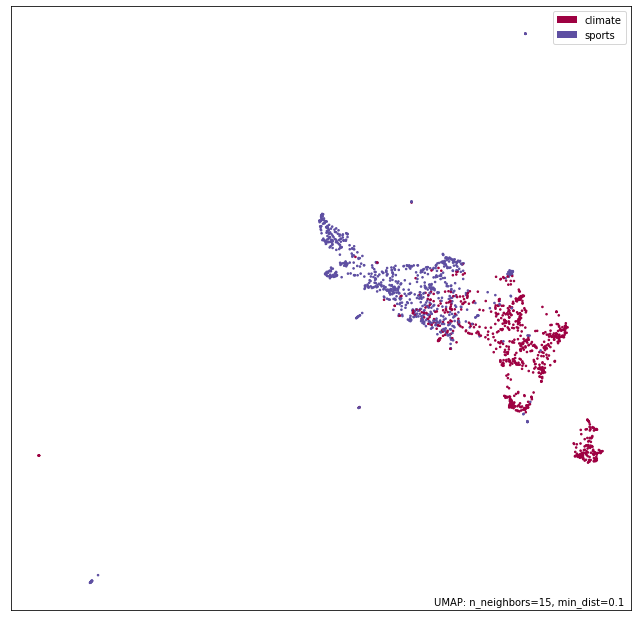

In [210]:
print(mapper.embedding_.shape)
import umap.plot

umap.plot.points(mapper, labels=np.array(train_labels))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:>

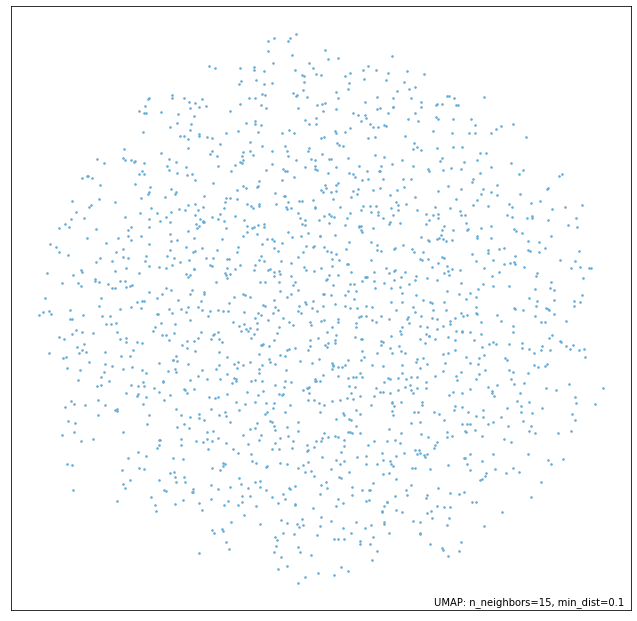

In [211]:
random_vect = np.random.normal(0, 1, [1657, 300])
mapper = umap.UMAP().fit(random_vect)

umap.plot.points(mapper)

As we can see from the visualizations, the first graph where we visualize the GLoVE based features for the labels climate and sports, we can observe the obvious clusters formed on the 2D plane. It indicates that our GLoVE embeddings are doing a good job at distinguishing features to train the classifiers. From the second visualization where we visualize the GLoVE for random vectors with the same dimensions as the documents, we do not observe any clusters.